In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats
import os
import datetime
import subprocess
from mech_dot_inp_gen import *
from visualizations import *
from optima import *
import jinja2
import copy
from experiment_reader import Experiment

In [2]:
class Processing:
    def __init__(self, species_txt: str, ) -> None:
        self.species = self.get_species(species_txt)
        #self.observables, self.not_observables = self.get_observables()
        self.observables = ['ADP', 'AMP', 'AMPK', 'AMPKA', 'AMPKA_ADP',
                            'AMPKA_AMP', 'AMPKA_ATP', 'AMPK_ADP', 'AMPK_AMP',
                            'AMPK_ATP', 'ATP', 'FKBP12', 'GLUCIN', 'GLUCOUT',
                            'MTOR', 'MTORA', 'RAP', 'RAPOUT', 'REF', 'RK',
                            'RKMTORA', 'ULK', 'ULKA']
        self.not_observables = list(set(self.species) - set(self.observables))

    def get_species(self, species_txt: str) -> list[str]:
        species = []
        with open(species_txt, 'r') as f:
            lines = f.readlines()
        for line in lines:
            for s in line.strip().split():
                species.append(s)
        print(len(species), species)
        return species

    def get_observables(self) -> tuple[list[str], list[str]]:
        dont_observe = []
        for s in self.species:
            if s == 'Q' or 'LKB1' in s or 'PP2A' in s or 'GLUT1' in s or 'RAP' in s or 'RK' in s or s in ['RHEB', 'PYRUVATE', 'AKT', 'TSCA']:
                dont_observe.append(s)
            elif s == 'FKBP12' or s == 'REF':
                dont_observe.append(s)
        observe = list(set(self.species) - set(dont_observe))
        print(len(observe), observe)
        return observe, dont_observe

In [3]:
class Model:
    def __init__(self, sheet_name: str, ics_df_path, # data_source: a pandas DataFrame
                 dont_observe: list[str], time_points: list[float],
                 time_course_vals: Union[dict[str, list[float]], float],
                 food: str, bibtex_str: Optional[str]=None, must_be_zero: list[str]=[],
                 uncertainty=False, inputs: dict[str, float]={'GLUCOUT': 6e-6}, # dict[stress_species: init_cc] = [rap extracell.: [mol/cm^3]]
                 experiment_data: Optional[pd.DataFrame]=None) -> None:
        self.model_name = sheet_name
        self.ics_df = pd.read_csv(ics_df_path, sep=',')
        self.ics_df['minconc'] = self.ics_df['minconc'].astype(float)
        self.ics_df['maxconc'] = self.ics_df['maxconc'].astype(float)
        self.ics_df['value'] = self.ics_df['value'].astype(float)
        self.ics_df.species = [s.upper() for s in self.ics_df.species]
        self.species = self.ics_df['species'].to_list()
        self.output_species = list(set(self.species) - set(dont_observe))
        self.time_points = time_points
        if isinstance(time_course_vals, float):
            self.time_course_vals = self.gen_time_course_vals(time_course_vals)
        else:
            self.time_course_vals = time_course_vals
        self.food = food
        self.must_be_zero = must_be_zero
        self.uncertainty = uncertainty
        self.inputs = inputs

        self.ranges = self.get_bounds()
        print(f"range values stored in model.ranges of length {len(self.ranges.keys())}")
        self.get_sigmas()

        # If no exp data given --> gen synthetic data
        self.experiment_data = experiment_data
        if experiment_data is not None:
            for s in self.experiment_data.columns:
                if 'STD' not in s.upper() and s.upper() != 'TIME' and s.upper() not in self.output_species:
                    self.output_species.append(s.upper())
            self.get_sigmas() # recalc sigmas in case new output species were added
            self.get_experiment_data(experiment_data, bibtex_str)
        else:
            self.gen_exp_data()


    def get_bounds(self) -> dict[str, tuple[float, float]]:
        bounds = dict()
        for _, row in self.ics_df.iterrows():
            if 'REF' not in row.species and row.species not in self.must_be_zero:
                if row.value < 1e-13:
                    lb = 1e-14
                    ub = 1e-13
                elif row.minconc == row.maxconc: #as a consequence if sth is [0, 0] --> IC is 0
                    lb = row.minconc
                    ub = row.maxconc
                else:
                    if row.value/2 >= row.minconc:
                        lb = (row.value/2)
                    else:
                        lb = row.minconc
                    if row.value*1.5 <= row.maxconc:
                        ub = (row.value*1.5)
                    else:
                        ub = row.maxconc
            bounds[row.species.upper()] = [lb, ub]
        return bounds

    def get_sigmas(self):
        self.sigmas = dict()
        for key, value in self.ranges.items():
            if self.uncertainty:
                if key in self.must_be_zero: # this line might be unnecessary, as I think we need sigma only if the species is an output
                    self.sigmas[key] = 0 #5e-18
                elif key in self.output_species:
                    if value[1] > value[0]:
                        self.sigmas[key] = ((value[1]-value[0])/8)
                    else:
                        self.sigmas[key] = 5e-14
            else:
                self.sigmas[key] = 2.5e-13

    def gen_time_course_vals(self, time_course_vals):
        species_time_course = {}
        for s in self.species:
            species_time_course[s] = np.ones(len(self.time_points)) * time_course_vals
        return species_time_course

    def gen_exp_data(self):
        self.exp_data = pd.DataFrame()
        self.exp_data['time'] = self.time_points
        for s in self.output_species:
            self.exp_data[s] = self.ics_df[self.ics_df['species'] == s].iloc[0, 2] # "exp_data" = value of the csv column
    
    def get_experiment_data(self, experiment_data: pd.DataFrame, bibtex_str):
        self.experiment = Experiment(experiment_data, 
                                     inputs=self.inputs,
                                     species_sigmas=self.sigmas,
                                     sheet_name=self.model_name,
                                     bounds=self.ranges,
                                     ics_df=self.ics_df,
                                     bibtex=bibtex_str,
                                     output_species=self.output_species)


In [13]:
class Genesis:
    def __init__(self, model: Model, max_digit = 4, prefix: str = "stressful_life"):
        self.model = model
        self.maxdigit = max_digit
        self.prefix = prefix

    def create_xml_files(self, output_xmls_path: str, num_of_xmls: int,
                         xml_template_path: str, prefix: str='', kiir=True) -> None:
        if not os.path.exists(output_xmls_path):
            os.makedirs(output_xmls_path)
        self.num_xmls = num_of_xmls
        self.output_dir = output_xmls_path
        env = jinja2.Environment(loader=jinja2.FileSystemLoader(os.path.dirname(xml_template_path)))
        self.template = env.get_template(os.path.basename(xml_template_path))

        if kiir:
            for i in range(1, num_of_xmls+1):
                np.random.seed(i+1)
                self.random_ics = self.get_random_ics()
                if self.model.experiment_data is not None:
                    self.model.exp_data = self.model.experiment.quantitated_exp_data(self.random_ics)
                self.make_xml_output(i, output_xmls_path, prefix)

    def get_random_ics(self) -> dict[str, float]:
        random_ics = {}
        if self.model.uncertainty:
            for key in self.model.species:
                if key not in self.model.must_be_zero:
                    random_ics[key] = np.random.uniform(*self.model.ranges[key])
                else:
                    random_ics[key] = 0
        else:
           random_ics = dict(zip(self.model.ics_df['species'], self.model.ics_df['value']))
        for key in self.model.inputs.keys():
            random_ics[key] = self.model.inputs[key]
        random_ics["REF"] = 1.0
        if 'no_gluc' not in self.model.food:
            random_ics['Q'] = 6e-6
        return random_ics

    def make_xml_output(self, file_index: int, output_xmls_path: str, prefix) -> None:
        dataPoints = [self.compileDataRow(row.values) for _, row in self.model.exp_data.iterrows()]
        if self.model.experiment_data is not None:
            output = self.template.render(ics=self.random_ics, variables=self.model.output_species,
                                      dataPoints=dataPoints, bib=self.model.experiment.bibtex)
        else:
            output = self.template.render(ics=self.random_ics, relsigmas=self.model.sigmas,
                              variables=self.model.output_species, dataPoints=dataPoints)
        padded_number = str(file_index).zfill(self.maxdigit)
        filename = f"{prefix}_{padded_number}.xml"
        with open(os.path.join(output_xmls_path, filename), 'w') as f:
            f.write(output)

    def compileDataRow(self, dataPoints):
        meas = "".join(f"<{v}>{{:.4e}}</{v}>" for v in self.model.exp_data.columns)
        return f"<dataPoint>{meas.format(*dataPoints)}</dataPoint>"

In [5]:
class Simulation:
    def __init__(self, gen: Genesis, xmls_in_one_opp: int) -> None:
      self.gen = gen
      self.get_xml_vec(xmls_in_one_opp)

    def get_xml_vec(self, xmls_in_one_opp) -> None:
      self.xmls = []
      for i in range(1, self.gen.num_xmls, xmls_in_one_opp):
          xml_cnt = np.arange(i, i+xmls_in_one_opp, 1) 
          self.xmls.append(xml_cnt)

    def opp_gen(self, opp_output_dir, opp_name_prefix, kiir, mech_file, food) -> None:
      self.opps = []
      self.indices = []
      self.food = food
      self.mech_file = mech_file
      self.mech_inp_name = self.mech_file.split('/')[-1].split('.inp')[0]
      for num in self.xmls:
          opp_filename = f"{opp_name_prefix}_{num[-1]}.opp"
          self.opps.append(opp_filename)
          self.indices.append(f"{num[-1]}")
          if kiir:
            opp_content = self.generate_opp_content(xml_folder=self.gen.output_dir,
                                                    num_xmls=num,
                                                    mech_file=mech_file,
                                                    name=self.gen.prefix)
            with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
              f.write(opp_content)

    def generate_opp_content(self, xml_folder: str, num_xmls: Union[list[int], list[list[int]]],
                             mech_file: str, name: str, time_limit: int = 50, thread_limit: int = 32,
                             settings_tag: str = "systems_biology", solver: str = "cantera") -> str:
      mech_name = mech_file.split('/')[-1].split('.inp')[0]
      yaml = mech_file.split('.inp')[0]

      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         {mech_name}
      MECH_FILE        {mech_file}
      COMPILE_{solver} {yaml}.yaml
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  {mech_name}
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS
      PLOTS FALSE

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml in num_xmls:
          padded_number = str(xml).zfill(self.gen.maxdigit)
          mechtest += f"      NAME {xml_folder}/{name}_{padded_number}.xml\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    @staticmethod
    def generate_opp_content_from_paths(xml_paths: list[str], mech_file: str,
                                        time_limit: int = 50, thread_limit: int = 32,
                                        settings_tag: str = "systems_biology", solver: str = "cantera") -> str:
      mech_name = mech_file.split('/')[-1].split('.inp')[0]
      yaml = mech_file.split('.inp')[0]

      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         {mech_name}
      MECH_FILE        {mech_file}
      COMPILE_{solver} {yaml}.yaml
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  {mech_name}
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS
      PLOTS FALSE

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml_path in xml_paths:
          mechtest += f"      NAME {xml_path}\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    def sim_runner(self, log_location:str = ''):
      self.parent_path = Path.cwd().parents[4] / "OptimaPP"

      if log_location == '':
        for idx, opp_file in enumerate(self.opps):
            command = ["bin/Release/OptimaPP", f"../Projects/Semmelweis_BCRN/BCRN/1_mechtest/{opp_file}"]
            print(f"Running: {' '.join(command)}")
            subprocess.run(command, check=True, cwd=self.parent_path)
      else:
        if not os.path.exists(log_location):
            os.makedirs(log_location)
        for idx, opp_file in enumerate(self.opps):
          command = ["bin/Release/OptimaPP", f"../Projects/Semmelweis_BCRN/BCRN/1_mechtest/{opp_file}"]
          print(f"Running: {' '.join(command)}")
          log_idx = self.xmls[idx][-1]
          with open(f"{log_location}/run_log_stac_starve_rap_{self.food}_{log_idx}.txt", "w") as log:
              subprocess.run(command, check=True, stdout=log, stderr=subprocess.STDOUT, cwd=self.parent_path)

In [6]:
class Natural_Selection:
    def __init__(self, sim: Simulation) -> None:
        self.sim = sim
        self.sim_data: dict[str, OptimaMechtest] = {}
        self.get_sim_data()
        #self.survival_of_the_fittest()

    def get_sim_data(self) -> None:
        for idx, key in enumerate(self.sim.indices):
            self.sim_data[key] = OptimaMechtest(job_name=self.sim.opps[idx],
                                                input_mech=self.sim.mech_inp_name)

    def sigma_range(self, meas, sim, sigma):
        radius = (sim-meas)/sigma
        return radius
    
    def isit_init(self, row):
        lut = self.sim.gen.model.ics_df
        rel_sigmas = self.sim.gen.model.sigmas
        for k, v in row.items():
            if k in self.condition_vars:
                right_row = lut[lut['species'] == k]

                meas = right_row['value'].iloc[0]

                radius = self.sigma_range(meas=meas, sim=v, sigma=rel_sigmas[k])

                if radius >= 4:
                    self.wrongdoers[k] += 1
                    return False

        return True
    
    def survival_of_the_fittest(self) -> None:
        self.good_xmls = []
        self.get_condition_vars()
        self.wrongdoers = {k: 0 for k in self.condition_vars}
        for idx in self.sim.indices:
            for xml_name, row in self.sim_data[idx].df_followed18.iterrows():
                all_ok = self.isit_init(row)
                if all_ok:
                    self.good_xmls.append(xml_name)
        print(f"Found {len(self.good_xmls)} good xmls")

    def get_condition_vars(self) -> None:
        self.condition_vars = ['RHEBA', 'AKTA', 'TSC', 'MTORA', 'ATP', 'ULK', 'GLUCIN']
# too big LKB1 activity could mean upregged AMPK biologically speaking
# ADP, AMP make complexes just like ATP, but for AMP/ADP the complex concentrations are comparable to the
# cc. of either ADP or AMP --> complex-bound ADP/AMP would throw the calculation off
# LKB1 and PP2A form complexes with the AMPKs --> their cc. should change --> not adequate conditions
    def filtering(self) -> None:
        data = copy.deepcopy(self.sim_data)
        first = True
        self.filtered_basal = pd.DataFrame()
        self.filtered_followed = pd.DataFrame()
        for k, v in data.items():
            v.df_basal.index = v.df_basal.index.str[7:-9]
            v.df_basal = v.df_basal.sort_index()
            if first:
                self.filtered_basal = v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]
                self.filtered_followed = v.df_followed18[[xml in self.good_xmls for xml in v.df_followed18.index]]
                first = False
            else:
                self.filtered_basal = pd.concat([self.filtered_basal, v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]],
                                        ignore_index=False)
                self.filtered_followed = pd.concat([self.filtered_followed, v.df_followed18[[xml in self.good_xmls for xml in v.df_followed18.index]]],
                                            ignore_index=False)

    def get_cov_cor(self, corr_xmls, keys: list[str]) -> None:
        self.dict_b = {}
        self.dict_f = {}
        self.dict_b_corr = {}
        self.dict_f_corr = {}
        self.dict_b_cov = {}
        self.dict_f_cov = {}
        for idx, alma in enumerate(corr_xmls):
            self.dict_f[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy()
            #self.dict_b[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy()
            #self.dict_b_corr[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy().corr()
            self.dict_f_corr[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy().corr()
            self.dict_f_cov[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy().cov()
            #self.dict_b_cov[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy().cov()

In [7]:
def plot_correlation_distance_heatmap(dict, corr_xmls, title: str, method='fro',
                                      save_fig=False, nat_select:Natural_Selection=None):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = dict[str(n1)].values
            mat2 = dict[str(n2)].values
            if method == 'kl':
                mu1 = nat_select.dict_f[str(n1)].mean()
                mu2 = nat_select.dict_f[str(n2)].mean()
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method, mu1=mu1, mu2=mu2)
            else:
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)
    plot_it(distance_matrix, corr_xmls, corr_xmls, method, save_fig, title)

def plot_dual_metric_heatmap(dict, keys,
                              method_lower='cmd', method_upper='frobenius',
                              title='Dual Distance Plot',
                              cmap_lower='Blues', cmap_upper='Reds',
                              save_fig=False,
                              nat_select_dict: dict[str, pd.DataFrame] = None):
    n = len(keys)
    data_lower = np.zeros((n, n))
    data_upper = np.zeros((n, n))

    # Compute both metrics for all pairs
    for i, n1 in enumerate(keys):
        for j, n2 in enumerate(keys):
            mat1 = dict[str(n1)]
            mat2 = dict[str(n2)]
            if method_lower == 'kl' or method_upper == 'kl':
                mu1 = nat_select_dict[str(n1)].mean()
                mu2 = nat_select_dict[str(n2)].mean()
            if i >= j:
                data_lower[i, j] = compute_matrix_distance(mat1, mat2, method_lower, mu1=mu1, mu2=mu2)
            elif i < j:
                data_upper[i, j] = compute_matrix_distance(mat1, mat2, method_upper, mu1=mu1, mu2=mu2)

    # Create masks
    mask_lower = np.triu(np.ones_like(data_lower, dtype=bool), k=1)
    mask_upper = np.tril(np.ones_like(data_upper, dtype=bool), k=0)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot lower triangle
    norm_lower = Normalize(vmin=np.min(data_lower[np.tril_indices(n, -1)]),
                           vmax=np.max(data_lower[np.tril_indices(n, -1)]))
    sns.heatmap(data_lower,
                mask=mask_lower,
                cmap=cmap_lower,
                annot=True,
                square=True,
                linewidths=0.5,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax)

    plt.xlabel('Number of XMLs')
    plt.ylabel('Number of XMLs')

    # Plot upper triangle
    norm_upper = Normalize(vmin=np.min(data_upper[np.triu_indices(n, 1)]),
                           vmax=np.max(data_upper[np.triu_indices(n, 1)]))
    sns.heatmap(data_upper,
                mask=mask_upper,
                cmap=cmap_upper,
                annot=True,
                square=True,
                linewidths=0.5,
                cbar=False,
                xticklabels=keys,
                yticklabels=keys,
                ax=ax)

    ax.set_xticklabels(keys, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(keys, rotation=0, fontsize=9)
    ax.set_title(title, fontsize=14, pad=12)

    # Add both colorbars
    cbar_ax1 = fig.add_axes([0.84, 0.25, 0.02, 0.5])  # Right colorbar
    sm1 = cm.ScalarMappable(cmap=cmap_upper, norm=norm_upper)
    sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
    cbar1.set_label(f'{method_upper.upper()} (upper)', rotation=270, labelpad=15)

    cbar_ax2 = fig.add_axes([0.0, 0.25, 0.02, 0.5])  # Left colorbar
    sm2 = cm.ScalarMappable(cmap=cmap_lower, norm=norm_lower)
    sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
    cbar2.set_label(f'{method_lower.upper()} (lower)', rotation=90, labelpad=15)

    #fig.patch.set_facecolor('#f8f6f6')
    #plt.tight_layout(rect=[0.1, 0, 0.9, 1])

    if save_fig:
        plt.savefig(f"pics/{title.replace(' ', '_')}.png", dpi=300)
        plt.savefig(f"pics/{title.replace(' ', '_')}.pdf")

    plt.show()

def plot_correlation_distance_heatmap_leodit(dict, corr_xmls, title: str, method='frobenius',
                                      save_fig=False, nat_select:Natural_Selection=None):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = dict[str(n1)]
            mat2 = dict[str(n2)]
            if method == 'kl':
                mu1 = nat_select.dict_b[str(n1)].mean()
                mu2 = nat_select.dict_b[str(n2)].mean()
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method, mu1=mu1, mu2=mu2)
            else:
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)
    plot_it(distance_matrix, corr_xmls, corr_xmls, method, save_fig, title)

In [8]:
proc = Processing('../input_files/unique_species.txt')
print(len(proc.observables), proc.observables)

114 ['AC', 'AC_GA', 'AC_GAA', 'ADP', 'AKT', 'AKTA', 'AMP', 'AMPK', 'AMPKA', 'AMPKA_ADP', 'AMPKA_ADP_PP2A', 'AMPKA_AMP', 'AMPKA_AMP_PP2A', 'AMPKA_ATP', 'AMPKA_ATP_PP2A', 'AMPKA_PP2A', 'AMPK_ADP', 'AMPK_ADP_LKB1', 'AMPK_AMP', 'AMPK_AMP_LKB1', 'AMPK_ATP', 'AMPK_ATP_LKB1', 'AMPK_LKB1', 'ATG5', 'ATG5T', 'ATG5_BCL2', 'ATP', 'AUT', 'BAX', 'BAXA', 'BCL2', 'BCL2_BAX', 'BCL2_PUMA', 'BEC1', 'BEC1A', 'BEC1_BCL2', 'BEC1_UVG', 'BID', 'CA2ER', 'CA2IC', 'CALPAIN', 'CALPAINA', 'CAMKKB', 'CAMKKBA', 'CAMP', 'CASP', 'CCH', 'CYTC', 'CYTCM', 'DAPK', 'DAPKA', 'DRAM', 'DS', 'EPAC', 'EPACA', 'FKBP12', 'GA', 'GAA', 'GABC', 'GBC', 'GLUCIN', 'GLUCOUT', 'GLUT1', 'GLUT1_GLUCIN', 'GLUT1_GLUCOUT', 'GPCRA', 'INSULIN', 'IP3', 'IP3R', 'IP3R_BCL2', 'IP3R_IP3', 'LKB1', 'MDM2', 'MTOR', 'MTORA', 'MTOR_RAP', 'NS', 'P53', 'P53A', 'P53A_BCL2', 'PHAG', 'PI3K', 'PI3KA', 'PIP2', 'PKA', 'PKAA', 'PKC', 'PKC_CA2IC', 'PLCE', 'PLCEA', 'PP2A', 'PREAUT', 'PROCASP', 'PUMA', 'PYRUVATE', 'Q', 'RAP', 'RAPOUT', 'REF', 'RHEB', 'RHEBA', 'RK', 

In [9]:
gluc_rap = pd.read_csv('../input_files/gluc_rap_ranges.csv')
combined = pd.read_csv('../input_files/combined_ranges.csv')

cols = ["minconc", "maxconc", "value"]
combined[cols] *= 1e-12

combined.to_csv('../input_files/combined_ranges_scaled.csv', index=False)

## Gen XMLs from Exp Data

In [ ]:
exp_xlsx_path = '../input_files/Mattiolo_2015_tester.xlsx' # Nitinesre valtoztat
xml_template = '../input_files/xml_template.xml' # Tesztre (nem kiserlet) --> 0_evaluate/input_files/std_xml_template.xml


# Read all sheets from Excel
all_sheets = pd.read_excel(exp_xlsx_path, sheet_name=None)  # dict of {sheet_name: DataFrame}

# Extract BibTeX from the last sheet
last_sheet_name = list(all_sheets.keys())[-1]
bibtex_df = all_sheets[last_sheet_name]
# Ha nem lenne header a BibTex-nel, akk ezzel kell beolvasni a sheetet: bibtex_df = pd.read_excel(exp_xlsx_path, sheet_name=last_sheet_name, header=None)

# Join all non-empty strings from the first column into a BibTeX string
bibtex_lines = bibtex_df.iloc[:, 0].dropna().astype(str).tolist()
bibtex_str = "\n".join(bibtex_lines)
bibtex_str = "\n".join(bibtex_lines).replace("_x000d_", "")  # Clean malformed carriage returns

#print("BibTex:\n", bibtex_str, "\n")
opp_output_dir = '../../1_mechtest'
num_xmls = 10

all_xml_paths = []

date = datetime.datetime.now()
date_prefix = f"{date.year}{date.month}{date.day}"

must_be_zero = ['Baxa', 'PUMA', 'RAP', 'RAPOUT', 'RK', 'RKMTORA', 'casp', 'p53a', 'tBid']
inputs = {'RAPOUT': 0}
inputs['GLUCOUT'] = 6e-6  # 6 mM glucose
food = 'gluc_no_rap' # bc we have glucose, but also rap (could be: gluc_no_rap, gluc_rap, no_gluc_no_rap, no_gluc_rap)

t = np.arange(0, 5070, 30)  # This is relevant only if no experimental data is given (then these will be the timepoints for the synthetic data)
sims: dict[str, Simulation] = {}

for i, sheet_name in enumerate(sorted(list(all_sheets.keys())[:-1])):  # Exclude the last sheet (= BibTeX)
    print(sheet_name)
    df = all_sheets[sheet_name]

    mod = Model(sheet_name=sheet_name, ics_df_path='../input_files/combined_ranges_scaled.csv',
                dont_observe=proc.not_observables, time_points=t, time_course_vals=7e-10,
                uncertainty=True, must_be_zero=must_be_zero, inputs=inputs, food=food,
                experiment_data=df, bibtex_str=bibtex_str)

    output_dir = f"/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/xml/{mod.experiment.bibtex['author'].split()[0][:-1]}_{mod.experiment.bibtex['year']}/{mod.experiment.name}"
    prefix = f"{mod.model_name}"

    gen = Genesis(mod, max_digit=4, prefix=prefix)
    gen.create_xml_files(output_xmls_path=output_dir,
                         num_of_xmls=num_xmls,
                         xml_template_path=xml_template,
                         prefix=prefix, kiir=True)

    sim = Simulation(gen, num_xmls)
    sim.opp_gen(opp_output_dir='/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/1_mechtest',
                opp_name_prefix=f'{date_prefix}_{prefix}_{food}',
                kiir=True, mech_file='/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/mech/starve_rap_combined.inp',
                food=food)

    sims[prefix] = sim

#for key, sim in sims.items():
#    sim.sim_runner(log_location=f'/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/logs/{key}')

Casp
range values stored in model.ranges of length 103
cyt
range values stored in model.ranges of length 103


In [11]:
mechs: dict[str, OptimaMechtest] = {}
for k in sims.keys():
    mechs[k] = OptimaMechtest(sims[k].opps[0], sims[k].mech_inp_name)

/home/szupernikusz/OptimaPP/outputs/202621_Casp_gluc_no_rap_10.opp/mechTestResults_starve_rap_combined.csv
True
/home/szupernikusz/OptimaPP/outputs/202621_cyt_gluc_no_rap_10.opp/mechTestResults_starve_rap_combined.csv
True


In [15]:
must_be_zero = ['Baxa', 'PUMA', 'RAP', 'RAPOUT', 'RK', 'RKMTORA', 'casp', 'p53a', 'tBid']
inputs = {'RAP': 0}
inputs['GLUCOUT'] = 6e-6  # 6 mM glucose
exp_conds = ['gluc_no_rap', 'gluc_rap', 'no_gluc_no_rap', 'no_gluc_rap']  # bc we have glucose, but also rap (could be: gluc_no_rap, gluc_rap, no_gluc_no_rap, no_gluc_rap)

date = datetime.datetime.now()
date_prefix = f"{date.year}{date.month}{date.day}"
t = np.arange(0, 5070, 30)
sims: dict[str, Simulation] = {}

num_xmls = 10
xml_template_path='../input_files/std_xml_template.xml'

for cond in exp_conds:  # Itt ird be a rap inputot a kvalitativ checkolasert. A GLUCOUT 1e-6 starve-ra, 6e-6 basal-re
    if cond == 'gluc_no_rap':
        inputs = {'RAPOUT': 0}
        inputs['GLUCOUT'] = 6e-6 
    elif cond == 'gluc_rap':
        inputs = {'RAPOUT': 1e-10}
        inputs['GLUCOUT'] = 6e-6 
    elif cond == 'no_gluc_no_rap':
        inputs = {'RAPOUT': 0}
        inputs['GLUCOUT'] = 1e-6
    elif cond == 'no_gluc_rap':
        inputs = {'RAPOUT': 1e-10}
        inputs['GLUCOUT'] = 1e-6
    else:
        raise Exception('cond must either be "starve" or "stac"')

    mod = Model(sheet_name=cond, ics_df_path='../input_files/combined_ranges_scaled.csv',
                dont_observe=proc.not_observables, time_points=t, time_course_vals=7e-10,
                uncertainty=True, must_be_zero=must_be_zero, inputs=inputs,
                food=cond)

    output_dir = f'/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/xml/testing_{cond}'
    prefix = f"{mod.model_name}"

    gen = Genesis(mod, max_digit=4, prefix=prefix)
    gen.create_xml_files(output_xmls_path=output_dir,
                         num_of_xmls=num_xmls,
                         xml_template_path=xml_template_path,
                         prefix=prefix, kiir=True)

    sim = Simulation(gen, num_xmls)
    sim.opp_gen(opp_output_dir='/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/1_mechtest',
                opp_name_prefix=f'{date_prefix}_testing_{cond}',
                kiir=True, mech_file='/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/mech/starve_rap_combined.inp',
                food=cond)

    sims[cond] = sim

#for key, sim in sims.items():
#    sim.sim_runner(log_location=f'/home/szupernikusz/Projects/Semmelweis_BCRN/BCRN/logs/{key}')

range values stored in model.ranges of length 103
range values stored in model.ranges of length 103
range values stored in model.ranges of length 103
range values stored in model.ranges of length 103


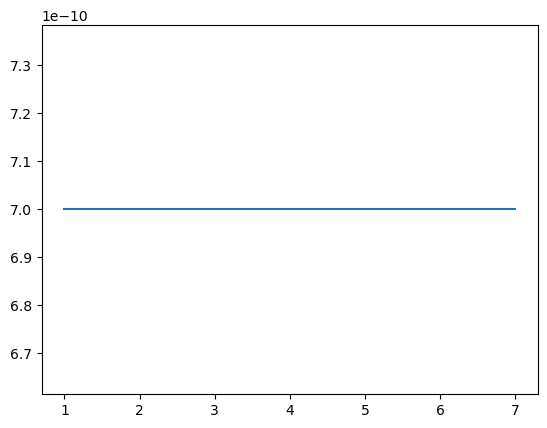

In [15]:
plt.plot(mechs['Casp'].orig_time_sim_df['Casp_0001']['CASP'])

In [54]:
mechs['Casp'].orig_time_sim_df

{'Casp_0001':            CASP
 1  7.645510e-14
 2  7.701880e-14
 3  7.758650e-14
 4  7.815830e-14
 5  7.873420e-14
 6  7.950850e-14
 7  8.107970e-14,
 'Casp_0002':             CASP
 8   8.578840e-14
 9   8.701560e-14
 10  8.825990e-14
 11  8.952170e-14
 12  9.080120e-14
 13  9.253570e-14
 14  9.610380e-14,
 'Casp_0003':             CASP
 15  4.280920e-14
 16  4.326490e-14
 17  4.372500e-14
 18  4.418980e-14
 19  4.465940e-14
 20  4.529320e-14
 21  4.658740e-14,
 'Casp_0004':             CASP
 22  5.305000e-14
 23  5.385670e-14
 24  5.467530e-14
 25  5.550590e-14
 26  5.634900e-14
 27  5.749280e-14
 28  5.984970e-14,
 'Casp_0005':             CASP
 29  2.840670e-14
 30  2.866370e-14
 31  2.892290e-14
 32  2.918430e-14
 33  2.944790e-14
 34  2.980310e-14
 35  3.052610e-14,
 'Casp_0006':             CASP
 36  1.365890e-14
 37  1.379600e-14
 38  1.393430e-14
 39  1.407370e-14
 40  1.421430e-14
 41  1.440390e-14
 42  1.479040e-14,
 'Casp_0007':             CASP
 43  6.060470e-14
 44  6.1665